In [1]:
# sys.path를 수정하여 모듈 경로를 설정
import sys
import os
import pandas as pd

# 프로젝트 루트 경로 추가
project_root = os.path.abspath("..")
sys.path.append(project_root)
import numpy as np

import module
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 모든 행 출력 설정
pd.set_option('display.max_rows', None)


In [2]:
df = module.file_load.load_아파트_key_xy좌표()
# backup/data/아파트_unique_key_위도경도.csv

In [3]:
origin = module.file_load.load_origin_train()

In [4]:
subway_df = module.file_load.load_지하철()
bus_df = module.file_load.load_버스()

In [5]:
bus_df.head(1)

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로


In [6]:
subdistance = module.preprocess.calculate_nearest_bus_distance(df, bus_df)

In [19]:
subdistance['nearest_bus_distance'].describe()

count    9032.000000
mean      120.956126
std        70.034445
min         1.295724
25%        69.710452
50%       109.334825
75%       157.260658
max       650.658737
Name: nearest_bus_distance, dtype: float64

In [7]:
subdistance.head(1)

,아파트_unique_key,좌표X,좌표Y,nearest_bus_distance
0,강남구_개포동_658-1_개포6차우성_1987,127.05721,37.476763,68.338514


In [8]:
module.preprocess.시_군_구_add(origin)
module.preprocess.아파트_unique_key_add(origin)

In [9]:
origin_filter = origin[['좌표X','좌표Y', '아파트_unique_key', 'target']]

In [10]:
merged_df = pd.merge(origin_filter, subdistance, on='아파트_unique_key', how='left')

In [11]:
merged_df.columns

Index(['좌표X_x', '좌표Y_x', '아파트_unique_key', 'target', '좌표X_y', '좌표Y_y',
       'nearest_bus_distance'],
      dtype='object')

In [12]:
from scipy.stats import pearsonr

# 상관계수 계산
correlation, _ = pearsonr(merged_df['nearest_bus_distance'], merged_df['target'])
correlation

0.1681901692036016

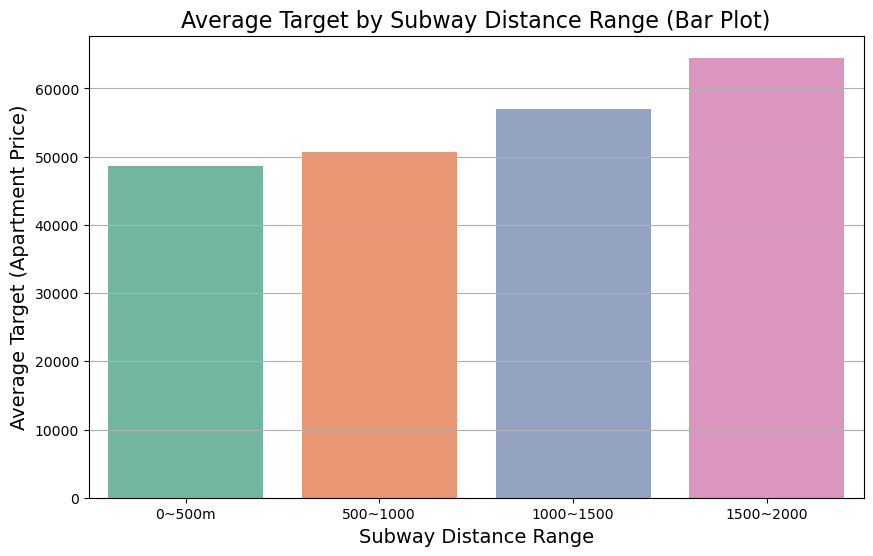

In [20]:
# 지하철 거리 범위 설정
merged_df['distance_range'] = pd.cut(merged_df['nearest_bus_distance'], bins=[0, 50, 100, 150, 200], labels=['0~500m', '500~1000', '1000~1500', '1500~2000'])

# 거리 범위별 Target 평균 계산
mean_target = merged_df.groupby('distance_range')['target'].mean().reset_index()

# 막대그래프 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='distance_range', y='target', data=mean_target, palette='Set2')
plt.title('Average Target by Subway Distance Range (Bar Plot)', fontsize=16)
plt.xlabel('Subway Distance Range', fontsize=14)
plt.ylabel('Average Target (Apartment Price)', fontsize=14)
plt.grid(True, axis='y')
plt.show()